In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import cv2
import os
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [77]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.batch1 = nn.BatchNorm2d(6)
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.batch2 = nn.BatchNorm2d(16)
        
        self.drop1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        
        self.drop2 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 14)

    def forward(self, x):
        # conv
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(self.batch1(F.relu(self.conv1(x))))
        x = self.pool(self.batch2(F.relu(self.conv2(x))))
        
        x = x.view(-1, 16 * 13 * 13)
        
        # fc
#         x = self.drop1(x)
        x = F.relu(self.fc1(x))
#         x = self.drop2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device', device)
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print(net)

device cpu
Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (batch1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2704, out_features=120, bias=True)
  (drop2): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=14, bias=True)
)


In [78]:
import numbers
import numpy as np
from PIL import ImageFilter

class GaussianSmoothing(object):
    def __init__(self, radius):
        if isinstance(radius, numbers.Number):
            self.min_radius = radius
            self.max_radius = radius
        elif isinstance(radius, list):
            if len(radius) != 2:
                raise Exception(
                    "`radius` should be a number or a list of two numbers")
            if radius[1] < radius[0]:
                raise Exception(
                    "radius[0] should be <= radius[1]")
            self.min_radius = radius[0]
            self.max_radius = radius[1]
        else:
            raise Exception(
                "`radius` should be a number or a list of two numbers")

    def __call__(self, image):
        radius = np.random.uniform(self.min_radius, self.max_radius)
        return image.filter(ImageFilter.GaussianBlur(radius))

In [79]:
from copy import copy, deepcopy
train_transform = torchvision.transforms.Compose([
                                            torchvision.transforms.Grayscale(),
                                            torchvision.transforms.Resize((64, 64)),
                                            GaussianSmoothing([0, 0.5]),
                                            torchvision.transforms.RandomApply([
                                              torchvision.transforms.RandomResizedCrop((64, 64), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                                            ], p=0.75),
                                            torchvision.transforms.ToTensor(),
#                                             torchvision.transforms.RandomErasing(p=0.30, scale=(0.05, 0.2)),
#                                             torchvision.transforms.Normalize((0.5, ), (0.5, ))
])

test_transform = torchvision.transforms.Compose([
                                            torchvision.transforms.Grayscale(),
                                            torchvision.transforms.Resize((64, 64)),
#                                             GaussianSmoothing([0, 5]),
                                            torchvision.transforms.ToTensor(),
                                            # torchvision.transforms.Normalize((0.5, ), (0.5, ))
])

set1 = torchvision.datasets.ImageFolder('..\\data\\out\\1n_final', transform=None)
set2 = torchvision.datasets.ImageFolder('..\\data\\out\\23_final', transform=None)
set3 = torchvision.datasets.ImageFolder('..\\data\\out\\gm_final', transform=None)
set4 = torchvision.datasets.ImageFolder('..\\data\\out\\yasser_final', transform=None)
fullset = torch.utils.data.ConcatDataset([set1, set2, set3, set4])
train_size = int(0.8 * len(fullset))
# train_size = len(fullset)
test_size = len(fullset) - train_size
trainset, testset = torch.utils.data.random_split(fullset, [train_size, test_size])

trainset.dataset = deepcopy(fullset)
for dt in trainset.dataset.datasets: 
  dt.transform = train_transform

for dt in testset.dataset.datasets: 
  dt.transform = test_transform

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = 100,
                                          shuffle = True,
                                          num_workers = 0,
                                          pin_memory = True)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size = 100,
                                         shuffle = True,
                                         num_workers = 0,
                                         pin_memory = True)
print(len(trainset), len(testset))

77930 19483


In [267]:
print(id(trainset.dataset.datasets[0]), trainset.dataset.datasets[0].transform)
print(id(testset.dataset.datasets[0]), testset.dataset.datasets[0].transform)

2591575158016 Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
    RandomApply(
    p=0.5
    RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.9, 1.1), interpolation=PIL.Image.BILINEAR)
)
    ToTensor()
)
2590076185856 Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
    ToTensor()
)


In [80]:
exp = 'exp_cbnn1_d0.5_0.4_bn_rc'

In [ ]:
%%time
x = 0
n = 100
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        x += 1

        # print statistics
        running_loss += loss.item()
        if x % n == n-1:
            PATH = '..\\data\\out\\model_' + exp + str(x) + '.pth'
            torch.save(net.state_dict(), PATH)
            
            print('%d [%d, %5d] loss: %.3f' %
                  (x, epoch + 1, i + 1, running_loss / n))
            running_loss = 0.0

PATH = '..\\data\\out\\model_' + exp + str(x) + '.pth'
print(PATH)
torch.save(net.state_dict(), PATH)
print('Finished Training')

99 [1,    99] loss: 1.566
199 [1,   199] loss: 0.430
299 [1,   299] loss: 0.186
399 [1,   399] loss: 0.105
499 [1,   499] loss: 0.079
599 [1,   599] loss: 0.058
699 [1,   699] loss: 0.048
799 [2,    19] loss: 0.007
899 [2,   119] loss: 0.046
999 [2,   219] loss: 0.033
1099 [2,   319] loss: 0.031
1199 [2,   419] loss: 0.027
1299 [2,   519] loss: 0.028
1399 [2,   619] loss: 0.025
1499 [2,   719] loss: 0.025
1599 [3,    39] loss: 0.009
1699 [3,   139] loss: 0.023
1799 [3,   239] loss: 0.019
1899 [3,   339] loss: 0.019
1999 [3,   439] loss: 0.019
2099 [3,   539] loss: 0.017
2199 [3,   639] loss: 0.018
2299 [3,   739] loss: 0.015
2399 [4,    59] loss: 0.009
2499 [4,   159] loss: 0.013
2599 [4,   259] loss: 0.015
2699 [4,   359] loss: 0.016
2799 [4,   459] loss: 0.013
2899 [4,   559] loss: 0.016
2999 [4,   659] loss: 0.015
3099 [4,   759] loss: 0.011
3199 [5,    79] loss: 0.009
3299 [5,   179] loss: 0.014
3399 [5,   279] loss: 0.011
3499 [5,   379] loss: 0.013
3599 [5,   479] loss: 0.010
369

In [3]:
test_transform = torchvision.transforms.Compose([
                                            torchvision.transforms.Grayscale(),
                                            torchvision.transforms.Resize((64, 64)),
                                            torchvision.transforms.ToTensor(),
])

testset = torchvision.datasets.ImageFolder('..\\data\\out\\aagard_final', transform=test_transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size = 100,
                                         shuffle = True,
                                         num_workers = 0,
                                         pin_memory = True)
print(len(testset))

13412


In [74]:
%%time
# wtf
correct = 0
total = 0
# 23
# num_images = 28032 
# 1n
# num_images = 26816

cm = np.zeros((14, 14), dtype=np.int64)
net.eval()
with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    cm += confusion_matrix(labels.numpy(), predicted.numpy(), labels=np.arange(14))
    total += labels.size(0)
    if total % 3000 == 0:
      print(total)
#     if total > 3000:
#       break
#     correct = (predicted == labels).sum().item()
#     if correct != predicted.shape[0]:
#       break

# print('Accuracy of the network on the 10000 test images: %d %%' % (
#     100 * correct / total))
net.train()

3000
6000
9000
12000
Wall time: 35.8 s


Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (drop1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=5408, out_features=120, bias=True)
  (drop2): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=14, bias=True)
)

In [75]:
total = np.sum(cm)
print('     0    1    2    3    4    5    6    7    8    9   10   11   12   13')
print(cm.astype(np.int32))
print('accuracy', np.trace(cm) / total)
print('total', np.trace(cm), total)

     0    1    2    3    4    5    6    7    8    9   10   11   12   13
[[1032    0    0   20    0    1   11   34    0    0   29    1    0    4]
 [ 128  491    0   82    2    0    9    3    0    0    0    0    0    0]
 [   2    0  857    5    0    0    0    2    0    0   51    0    0    4]
 [   0    0    0 1007    0    0   58    2    0    1    6    1    2  113]
 [   0    1    0    1  690    0    0    0    0    0    0   34    0    0]
 [   0    1    0   17    1  957    1    5    0    0    8    0   23    1]
 [   0    0    0    0    0    0 1083    0    0    0    0    0    0    0]
 [   1    0    0    1    0    0    5  963    0    0   38    0    3    1]
 [   0    0    0    5    0    1    1   94  444    0    4    0  264    1]
 [   0    0    0    0    0    0    0   18    0  853   31    0    0    0]
 [   0    0    0    0    0    0    8    0    0    2 1014    0    0    8]
 [   2    0    0    2   16    0    1    0    0    0    1  743    0    0]
 [   0    0    0    0    0    0    0    0    0    0 

In [76]:
cm.diagonal() / cm.sum(1)

array([0.91166078, 0.68671329, 0.93051031, 0.84621849, 0.95041322,
       0.94378698, 1.        , 0.95158103, 0.54545455, 0.94567627,
       0.98255814, 0.97124183, 0.99802567, 1.        ])

In [47]:
%matplotlib inline
def sw(im):
  plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


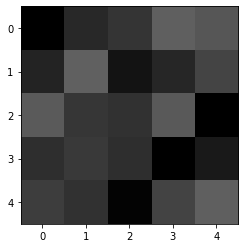

In [77]:
sw(net.conv1.weight[5,...].detach().numpy().squeeze(0))
# net.conv2.weight.shape

In [73]:
# lol
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(1, 16, 5)
#         self.batch1 = nn.BatchNorm2d(6)
        
        self.conv2 = nn.Conv2d(16, 32, 5)
#         self.batch2 = nn.BatchNorm2d(16)
        
        self.drop1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32 * 13 * 13, 120)
        
        self.drop2 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 14)

    def forward(self, x):
        # conv
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(self.batch1(F.relu(self.conv1(x))))
#         x = self.pool(self.batch2(F.relu(self.conv2(x))))
        
        x = x.view(-1, 32 * 13 * 13)
        
        # fc
        x = self.drop1(x)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device', device)
net = Net()
net.to(device)
# PATH = '..//data//out//model_exp_model9_4390.pth'
# PATH = '..//data//out//model_exp_model12_6770.pth'
# PATH = '..//data//out//model_exp_cbnn1_d0.4_0.3_7800.pth'
PATH = '..//data//out//model_exp_cbnn3_d0.5_0.4_rc_re_7800.pth'
net.load_state_dict(torch.load(PATH))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print(net)
net.eval()

device cpu
Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (drop1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=5408, out_features=120, bias=True)
  (drop2): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=14, bias=True)
)


Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (drop1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=5408, out_features=120, bias=True)
  (drop2): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=14, bias=True)
)

In [288]:
image_path = '..\\data\\out\\a22.png'
board_im = cv2.imread(image_path, 0)

transform = torchvision.transforms.Compose([
  # torchvision.transforms.Grayscale(),
  torchvision.transforms.Resize((8*64, 8*64)),
#   GaussianSmoothing([0, 0.5]),
  torchvision.transforms.ToTensor(),
  # torchvision.transforms.Normalize((0.5, ), (0.5, ))
])

im = Image.fromarray(board_im)
im = transform(im)
dim = 64
tensors = [im[:, dim*k: dim*(k+1), dim*j: dim*(j+1)] for k in range(8) for j in range(8)]
# sw(tensors[0].numpy()[np.newaxis, ...] * 255)
# print(tensors[0].numpy()[np.newaxis, ...])
images = torch.stack(tensors)
outputs = net(images)
_, predicted = torch.max(outputs.data, 1)
print(predicted)
print(get_fen_str(predicted))

tensor([ 5,  2,  0,  4,  1,  0,  2,  5,  3,  3,  3,  3,  3,  3,  3,  3, 13,  6,
        13,  6, 13,  6, 13,  6,  6, 13,  6, 13,  6, 13,  6, 13, 13,  6, 13,  6,
        13,  6, 13,  6,  6, 13,  6, 13,  6, 13,  6, 13, 10, 10, 10, 10, 10, 10,
        10, 10, 12,  9,  7, 11,  8,  7,  9, 12])
rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR%20w%20KQkq%20-%200%201


In [214]:
net(images[0,...].unsqueeze(0)).data

tensor([[ 21.2408,   4.6339,   7.8342,  27.8178,   2.3713,  23.7090,  -7.5043,
           9.4107,  -3.8514, -15.6906,  -8.4994,  -1.2262, -13.4902, -27.4314]])

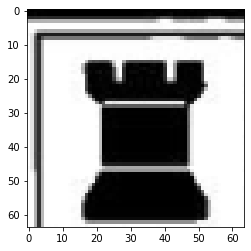

In [124]:
sw((images[0] * 255).view(64, 64, 1).numpy().astype(np.uint8))

In [88]:
import io
piecenames = ['bb', 'bk', 'bn', 'bp', 'bq', 'br', 'em', 'wb', 'wk', 'wn', 'wp', 'wq', 'wr', 'em']

def get_fen_str(predicted):
  with io.StringIO() as s:
    for row in range(8):
      empty = 0
      for cell in range(8):
        c = piecenames[predicted[row*8 + cell]]
        if c[0] in ('w', 'b'):
          if empty > 0:
            s.write(str(empty))
            empty = 0
          s.write(c[1].upper() if c[0] == 'w' else c[1].lower())
        else:
          empty += 1

      if empty > 0:
        s.write(str(empty))
      s.write('/')
    # Move one position back to overwrite last '/'
    s.seek(s.tell() - 1)
    # If you do not have the additional information choose what to put
    # s.write(' w KQkq - 0 1')
    s.write('%20w%20KQkq%20-%200%201')
    return s.getvalue()

In [77]:
def pil_loader(path):
  # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
  with open(path, 'rb') as f:
    img = Image.open(f)
    return img.convert('L')
# print(np.array(pil_loader(image_path)))
print(transform(pil_loader(image_path)))

tensor([[[0.0118, 0.0000, 0.0078,  ..., 0.0078, 0.0471, 0.0196],
         [0.0000, 0.0078, 0.0235,  ..., 0.2314, 0.2471, 0.1490],
         [0.1608, 0.1569, 0.1686,  ..., 0.9961, 0.9725, 0.7294],
         ...,
         [0.9725, 1.0000, 0.9922,  ..., 0.9922, 0.9804, 0.9961],
         [0.9882, 0.9765, 0.9922,  ..., 0.6196, 0.6118, 0.6118],
         [0.1804, 0.1961, 0.1373,  ..., 0.0784, 0.0745, 0.0706]]])


In [61]:
from PIL import Image

%matplotlib inline
def sbw(im):
  plt.imshow(im, cmap='gray', vmin=0, vmax=255)

def sw(im):
  plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
  plt.show()

In [139]:
piecenames = ['BlackBishop', 'BlackKing', 'BlackKnight', 'BlackPawn', 'BlackQueen', 'BlackRook', 'BlackSpace', 'WhiteBishop', 'WhiteKing', 'WhiteKnight', 'WhitePawn', 'WhiteQueen', 'WhiteRook', 'WhiteSpace']

In [292]:
from PIL import Image

folder = '..\\data\\out\\yasser_final'
x = 0
cm = np.zeros((14, 14), dtype=np.int64)

def pil_loader(path):
  # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
  with open(path, 'rb') as f:
    img = Image.open(f)
    return img.convert('RGB')
      
for i, piece in enumerate(sorted(os.listdir(folder))):
  folder2 = os.path.join(folder, piece)
  if os.path.isfile(folder2):
    continue
  for j, filename in enumerate(sorted(os.listdir(folder2))):
    fullname = os.path.join(folder2, filename)
    im = pil_loader(fullname)
    im = torchvision.transforms.functional.to_grayscale(im)
    im = torchvision.transforms.functional.resize(im, (64, 64), Image.BILINEAR)
    im = torchvision.transforms.functional.to_tensor(im)
    im = im.unsqueeze(0)

# #     im = im.unsqueeze(0).type(torch.float32)
# #     im = cv2.imread(fullname, 0)
# #     im = cv2.resize(im, (64, 64)).astype(np.float32)
# #     im = torch.from_numpy(im).unsqueeze(0).unsqueeze(0)

    outputs = net(im)
    _, predicted = torch.max(outputs.data, 1)
#     piece = piecenames[predicted]
#     newpath = os.path.join(folder2, piece + '_con1_' + str(x) + '.png')
#     print(newpath)
#     os.rename(fullname, newpath)
    cm[i][predicted] += 1
    x += 1
    if x % 1000 == 0:
      print(x)
#     print(predicted)
#     break
#   break

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [4]:
import torchvision.models as models
resnet50 = models.resnet50(pretrained=True, progress=False)

In [72]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
vgg16.classifier[-2].register_forward_hook(get_activation('fc2'))


NameError: name 'vgg16' is not defined

In [5]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
resnet50.avgpool.register_forward_hook(get_activation('fc2'))

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [57]:
%%time
# res = np.empty((26816, 2048), dtype=np.float32)
# res = np.empty((28, 2048), dtype=np.float32)
x = 0
with torch.no_grad():
  for data in trainloader:
    images, labels = data[0].to(device), data[1].to(device)
    n = images.shape[0]
    
    output = resnet50(images)
#     res[x: x + n,:] = activation['fc2'].view(-1, 2048)
    act = activation['fc2'].view(-1, 2048)
    break

    x += n
    if x % 1000 == 0:
      print('x', x)

KeyboardInterrupt: 

In [11]:
gt = res

In [19]:
import sklearn

In [40]:
# act[0].shape, gt.shape
# print(sklearn.metrics.pairwise.euclidean_distances(act, gt).argmin(axis=1) / 2)
# print(labels)
print(gt)
print(act[0])

[[0.07750261 0.8814883  1.3272038  ... 0.94399077 0.12172581 0.5190152 ]
 [0.53081465 1.1889176  0.87304455 ... 0.57789785 0.25939602 0.1244965 ]
 [0.15970045 0.5196016  0.4135991  ... 0.508797   1.1560974  0.50378776]
 ...
 [0.4481257  0.25660902 0.21730614 ... 0.10816965 0.05452814 0.22506453]
 [0.22708838 0.12393332 0.39125115 ... 0.03920951 0.42045596 0.23482805]
 [0.22708838 0.12393332 0.39125115 ... 0.03920951 0.42045596 0.23482805]]
tensor([0.2012, 0.2250, 0.1623,  ..., 0.2641, 0.2916, 0.1376])


In [58]:
%%time
cm = np.zeros((14, 14))
x = 0
with torch.no_grad():
  for data in trainloader:
    images, labels = data[0].to(device), data[1].to(device)
    n = images.shape[0]
    cm += confusion_matrix(labels, bestLabels[x: x+n], labels=np.arange(14))
    x += n
    if x % 1000 == 0:
      print('x', x)

NameError: name 'bestLabels' is not defined

In [90]:
labels, bestLabels[-15:].flatten()

(tensor([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]),
 array([11,  3,  7,  8, 11, 13,  1, 13,  3,  3,  5,  6, 11,  6,  9],
       dtype=int32))

In [502]:
activation['fc2'].view(-1, 2048).shape

torch.Size([100, 2048])

In [76]:
import pickle
pickle.dump(res, open('..\\data\\out\\res2.pkl', 'wb'))

In [2]:
# res = np.load('..\\data\\out\\res.pkl')
import pickle
res = pickle.load(open('..\\data\\out\\res2.pkl', 'rb'))

In [77]:
%%time
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, int(1e6), 1.0)
ret, bestLabels, centers = cv2.kmeans(res, 14, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

Wall time: 11.7 s
